# Kepler Exoplanet Search Results

## Conjunto de datos: Kepler Exoplanet Search Results

### Descripción
#### Context
The Kepler Space Observatory is a NASA-build satellite that was launched in 2009. The telescope is dedicated to searching for exoplanets in star systems besides our own, with the ultimate goal of possibly finding other habitable planets besides our own. The original mission ended in 2013 due to mechanical failures, but the telescope has nevertheless been functional since 2014 on a "K2" extended mission.

Kepler had verified 1284 new exoplanets as of May 2016. As of October 2017 there are over 3000 confirmed exoplanets total (using all detection methods, including ground-based ones). The telescope is still active and continues to collect new data on its extended mission.

#### Content
This dataset is a cumulative record of all observed Kepler "objects of interest" — basically, all of the approximately 10,000 exoplanet candidates Kepler has taken observations on.

This dataset has an extensive data dictionary, which can be accessed <a href="https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html"> here</a> . Highlightable columns of note are:

<ul>
  <li>kepoi_name: A KOI is a target identified by the Kepler Project that displays at least one transit-like sequence within Kepler time-series photometry that appears to be of astrophysical origin and initially consistent with a planetary transit hypothesis</li>
  <li>kepler_name: [These names] are intended to clearly indicate a class of objects that have been confirmed or validated as planets—a step up from the planet candidate designation.</li>
  <li>koi_disposition: The disposition in the literature towards this exoplanet candidate. One of CANDIDATE, FALSE POSITIVE, NOT DISPOSITIONED or CONFIRMED.</li>
  <li>koi_pdisposition: The disposition Kepler data analysis has towards this exoplanet candidate. One of FALSE POSITIVE, NOT DISPOSITIONED, and CANDIDATE.</li>
  <li>koi_score: A value between 0 and 1 that indicates the confidence in the KOI disposition. For CANDIDATEs, a higher value indicates more confidence in its disposition, while for FALSE POSITIVEs, a higher value indicates less confidence in that disposition.</li>
</ul>

#### Acknowledgements
This dataset was published as-is by NASA. You can access the original table here. More data from the Kepler mission is available from the same source <a href="https://exoplanetarchive.ipac.caltech.edu/docs/data.html">here</a>.

#### Inspiration
<ul>
    <li>How often are exoplanets confirmed in the existing literature disconfirmed by measurements from Kepler? How about the other way round?</li>
    <li>What general characteristics about exoplanets (that we can find) can you derive from this dataset?</li>
    <li>What exoplanets get assigned names in the literature? What is the distribution of confidence scores?</li>
</ul>

See also: the Kepler Labeled Time Series and Open Exoplanets Catalogue datasets.

Descarga de los ficheros
<a href="https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results">https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results<a/>

## Imports

In [125]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [126]:
import warnings
# Ignoramos algunos warnings que se producen al graficar
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')

## Funciones auxiliares 

In [127]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [128]:
# Función que separa las variables de entrada y salida
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [129]:
# Transormador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._oh = OneHotEncoder()
        self._columns = None
        
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh.toarray(), 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [130]:
# Transformador diseñado para escalar de manera sencilla únicamente unas columnas seleccionadas
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        scale_attrs = X_copy[self.attributes]
        robust_scaler = RobustScaler()
        X_scaled = robust_scaler.fit_transform(scale_attrs)
        X_scaled = pd.DataFrame(X_scaled, columns=self.attributes, index=X_copy.index)
        for attr in self.attributes:
            X_copy[attr] = X_scaled[attr]
        return X_copy

In [131]:
# Transformador creado para sustituir outliers con la mediana
class SubstituteOutliersMedian(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = list(attributes)
    def fit(self, X, y=None):
        # Calculamos cuantiles, límites e medianas por atributo y los guardamos
        Q1 = X[self.attributes].quantile(0.25)
        Q3 = X[self.attributes].quantile(0.75)
        IQR = Q3 - Q1

        self.lim_inf = Q1 - 1.5 * IQR
        self.lim_sup = Q3 + 1.5 * IQR
        self.median = X[self.attributes].median()

        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
    
        for attr in self.attributes:
            is_outlier = (X_copy[attr] < self.lim_inf[attr]) | (X_copy[attr] > self.lim_sup[attr])
            # Reemplazamos solo donde is_outlier == True
            X_copy.loc[is_outlier, attr] = self.median[attr]
        
        return X_copy

In [132]:
# Transformador creado para sustituir outliers con la media
class SubstituteOutliersMean(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = list(attributes)
    def fit(self, X, y=None):
        # Calculamos cuantiles, límites e medianas por atributo y los guardamos
        Q1 = X[self.attributes].quantile(0.25)
        Q3 = X[self.attributes].quantile(0.75)
        IQR = Q3 - Q1

        self.lim_inf = Q1 - 1.5 * IQR
        self.lim_sup = Q3 + 1.5 * IQR
        self.mean = X[self.attributes].mean()

        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
    
        for attr in self.attributes:
            is_outlier = (X_copy[attr] < self.lim_inf[attr]) | (X_copy[attr] > self.lim_sup[attr])
            # Reemplazamos solo donde is_outlier == True
            X_copy.loc[is_outlier, attr] = self.mean[attr]
        
        return X_copy

In [133]:
# Función que llena los valores nulos de un dataframe con la mediana o elimia las filas con valores nulos
def fill_null_values(df):
    for column in df.columns:
        if df[column].isna().any() == np.True_:
            try: 
                mediana = df[column].median()
                df[column] = df[column].fillna(mediana)
            except:
                df.dropna(subset=[column], inplace=True)
        else:
            pass
    return df

## Lectura del conjunto de datos

In [134]:
df = pd.read_csv("cumulative.csv")

## Visualización preliminar de la información

In [135]:
df

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,9560,10031643,K07984.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9560,9561,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9561,9562,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9562,9563,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,...,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385


In [136]:
df.describe()

,rowid,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,9564.000000,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,...,9081.000000,9201.000000,9096.000000,9096.000000,9201.000000,9096.000000,9096.000000,9564.000000,9564.000000,9563.000000
mean,4782.500000,7.690628e+06,0.480829,0.188206,0.231598,0.194898,0.120033,75.671358,0.002148,-0.002148,...,-162.265059,4.310157,0.120738,-0.143161,1.728712,0.362292,-0.394806,292.060163,43.810433,14.264606
std,2761.033321,2.653459e+06,0.476928,0.390897,0.421875,0.396143,0.325018,1334.744046,0.008236,0.008236,...,72.746348,0.432606,0.132837,0.085477,6.127185,0.930870,2.168213,4.766657,3.601243,1.385448
min,1.000000,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,2391.750000,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,...,-198.000000,4.218000,0.042000,-0.196000,0.829000,0.129000,-0.250000,288.660770,40.777173,13.440000
50%,4782.500000,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,...,-160.000000,4.438000,0.070000,-0.128000,1.000000,0.251000,-0.111000,292.261125,43.677504,14.520000
75%,7173.250000,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,...,-114.000000,4.543000,0.149000,-0.088000,1.345000,0.364000,-0.069000,295.859160,46.714611,15.322000
max,9564.000000,1.293514e+07,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,...,0.000000,5.364000,1.472000,0.000000,229.908000,33.091000,0.000000,301.720760,52.336010,20.003000


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              9564 non-null   int64  
 1   kepid              9564 non-null   int64  
 2   kepoi_name         9564 non-null   object 
 3   kepler_name        2294 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_pdisposition   9564 non-null   object 
 6   koi_score          8054 non-null   float64
 7   koi_fpflag_nt      9564 non-null   int64  
 8   koi_fpflag_ss      9564 non-null   int64  
 9   koi_fpflag_co      9564 non-null   int64  
 10  koi_fpflag_ec      9564 non-null   int64  
 11  koi_period         9564 non-null   float64
 12  koi_period_err1    9110 non-null   float64
 13  koi_period_err2    9110 non-null   float64
 14  koi_time0bk        9564 non-null   float64
 15  koi_time0bk_err1   9110 non-null   float64
 16  koi_time0bk_err2   9110 

In [138]:
# Verificamos si hay valores nulos
df.isna().any()

rowid                False
kepid                False
kepoi_name           False
kepler_name           True
koi_disposition      False
koi_pdisposition     False
koi_score             True
koi_fpflag_nt        False
koi_fpflag_ss        False
koi_fpflag_co        False
koi_fpflag_ec        False
koi_period           False
koi_period_err1       True
koi_period_err2       True
koi_time0bk          False
koi_time0bk_err1      True
koi_time0bk_err2      True
koi_impact            True
koi_impact_err1       True
koi_impact_err2       True
koi_duration         False
koi_duration_err1     True
koi_duration_err2     True
koi_depth             True
koi_depth_err1        True
koi_depth_err2        True
koi_prad              True
koi_prad_err1         True
koi_prad_err2         True
koi_teq               True
koi_teq_err1          True
koi_teq_err2          True
koi_insol             True
koi_insol_err1        True
koi_insol_err2        True
koi_model_snr         True
koi_tce_plnt_num      True
k

In [139]:
# Porcentaje de nulos en cada columna
(df.isnull().sum() / len(df)) * 100

rowid                  0.000000
kepid                  0.000000
kepoi_name             0.000000
kepler_name           76.014220
koi_disposition        0.000000
koi_pdisposition       0.000000
koi_score             15.788373
koi_fpflag_nt          0.000000
koi_fpflag_ss          0.000000
koi_fpflag_co          0.000000
koi_fpflag_ec          0.000000
koi_period             0.000000
koi_period_err1        4.746968
koi_period_err2        4.746968
koi_time0bk            0.000000
koi_time0bk_err1       4.746968
koi_time0bk_err2       4.746968
koi_impact             3.795483
koi_impact_err1        4.746968
koi_impact_err2        4.746968
koi_duration           0.000000
koi_duration_err1      4.746968
koi_duration_err2      4.746968
koi_depth              3.795483
koi_depth_err1         4.746968
koi_depth_err2         4.746968
koi_prad               3.795483
koi_prad_err1          3.795483
koi_prad_err2          3.795483
koi_teq                3.795483
koi_teq_err1         100.000000
koi_teq_

In [140]:
print("Número de nulls en kepler_name: ", df["kepler_name"].isnull().sum())
print("Número de nulls en koi_teq_err1: ", df["koi_teq_err1"].isnull().sum())
print("Número de nulls en koi_teq_err2: ", df["koi_teq_err2"].isnull().sum())

Número de nulls en kepler_name:  7270
Número de nulls en koi_teq_err1:  9564
Número de nulls en koi_teq_err2:  9564


In [141]:
# Comprobamos si hay valores infinitos
df.isin([np.inf, -np.inf]).any()

rowid                False
kepid                False
kepoi_name           False
kepler_name          False
koi_disposition      False
koi_pdisposition     False
koi_score            False
koi_fpflag_nt        False
koi_fpflag_ss        False
koi_fpflag_co        False
koi_fpflag_ec        False
koi_period           False
koi_period_err1      False
koi_period_err2      False
koi_time0bk          False
koi_time0bk_err1     False
koi_time0bk_err2     False
koi_impact           False
koi_impact_err1      False
koi_impact_err2      False
koi_duration         False
koi_duration_err1    False
koi_duration_err2    False
koi_depth            False
koi_depth_err1       False
koi_depth_err2       False
koi_prad             False
koi_prad_err1        False
koi_prad_err2        False
koi_teq              False
koi_teq_err1         False
koi_teq_err2         False
koi_insol            False
koi_insol_err1       False
koi_insol_err2       False
koi_model_snr        False
koi_tce_plnt_num     False
k

In [142]:
df["koi_disposition"].value_counts()

koi_disposition
FALSE POSITIVE    5023
CONFIRMED         2293
CANDIDATE         2248
Name: count, dtype: int64

In [143]:
# Colocamos la columna rowid como indice
df.set_index("rowid", inplace=True)
df

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10031643,K07984.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,1,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9561,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9562,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757


## Preprocesamiento del conjunto de datos

In [144]:
# Copiamos el conjunto de datos para no alterar el original
df_copy = df.copy()

In [145]:
# Eliminamos la columna "kepler_name", "kepoi_name", "koi_teq_err1", "koi_teq_err2" ya que el número de nulls es alto y no aportan mucho
df_copy = df_copy.drop(["kepler_name","kepoi_name","koi_teq_err1","koi_teq_err2"], axis=1)

In [146]:
# Usamos la función fill nulls
df_copy = fill_null_values(df_copy)
df_copy

,kepid,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10797460,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
3,10811496,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
4,10848459,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
5,10854555,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10031643,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,1,8.589871,1.846000e-04,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9561,10090151,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,0.527699,1.160000e-07,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9562,10128825,CANDIDATE,CANDIDATE,0.497,0,0,0,0,1.739849,1.780000e-05,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757


In [147]:
# División del conjunto de datos en X, y
X_df, y_df = remove_labels(df_copy, "koi_disposition")
X_df

,kepid,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10797460,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
3,10811496,FALSE POSITIVE,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
4,10848459,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
5,10854555,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10031643,FALSE POSITIVE,0.000,0,0,0,1,8.589871,1.846000e-04,-1.846000e-04,...,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
9561,10090151,FALSE POSITIVE,0.000,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9562,10128825,CANDIDATE,0.497,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757


In [148]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9218 entries, 1 to 9564
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9218 non-null   int64  
 1   koi_pdisposition   9218 non-null   object 
 2   koi_score          9218 non-null   float64
 3   koi_fpflag_nt      9218 non-null   int64  
 4   koi_fpflag_ss      9218 non-null   int64  
 5   koi_fpflag_co      9218 non-null   int64  
 6   koi_fpflag_ec      9218 non-null   int64  
 7   koi_period         9218 non-null   float64
 8   koi_period_err1    9218 non-null   float64
 9   koi_period_err2    9218 non-null   float64
 10  koi_time0bk        9218 non-null   float64
 11  koi_time0bk_err1   9218 non-null   float64
 12  koi_time0bk_err2   9218 non-null   float64
 13  koi_impact         9218 non-null   float64
 14  koi_impact_err1    9218 non-null   float64
 15  koi_impact_err2    9218 non-null   float64
 16  koi_duration       9218 non-n

In [149]:
# Se utiliza CustomOneHotEncoder para codificar las columnas categoricas
one_hot_encoder = CustomOneHotEncoder()
X_df = one_hot_encoder.fit_transform(X_df)

In [150]:
X_df

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,koi_pdisposition_CANDIDATE,koi_pdisposition_FALSE POSITIVE,koi_tce_delivname_q1_q16_tce,koi_tce_delivname_q1_q17_dr24_tce,koi_tce_delivname_q1_q17_dr25_tce
rowid,,,,,,,,,,,,,,,,,,,,,
1,10797460,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,...,0.105,-0.061,291.93423,48.141651,15.347,1.0,0.0,0.0,0.0,1.0
2,10797460,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,...,0.105,-0.061,291.93423,48.141651,15.347,1.0,0.0,0.0,0.0,1.0
3,10811496,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,...,0.233,-0.078,297.00482,48.134129,15.436,0.0,1.0,0.0,0.0,1.0
4,10848459,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,...,0.201,-0.067,285.53461,48.285210,15.597,0.0,1.0,0.0,0.0,1.0
5,10854555,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,...,0.334,-0.133,288.75488,48.226200,15.509,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,10031643,0.000,0,0,0,1,8.589871,1.846000e-04,-1.846000e-04,132.016100,...,0.313,-0.228,298.74921,46.973351,14.478,0.0,1.0,0.0,0.0,1.0
9561,10090151,0.000,0,1,1,0,0.527699,1.160000e-07,-1.160000e-07,131.705093,...,0.237,-0.079,297.18875,47.093819,14.082,0.0,1.0,0.0,0.0,1.0
9562,10128825,0.497,0,0,0,0,1.739849,1.780000e-05,-1.780000e-05,133.001270,...,0.341,-0.114,286.50937,47.163219,14.757,1.0,0.0,0.0,0.0,1.0


### Calculo de Correlaciones

In [151]:
# Transformamos la variable de salida a numérica para calcular correlaciones
df_proc = X_df.join(y_df)
df_proc["koi_disposition"] = df_proc["koi_disposition"].factorize()[0]

In [152]:
# Calculamos correlaciones
corr_matrix = df_proc.corr()
corr_matrix["koi_disposition"].sort_values(ascending=False)

koi_disposition                      1.000000
koi_steff_err1                       0.176301
koi_duration_err1                    0.152128
koi_time0bk_err1                     0.140973
koi_tce_delivname_q1_q16_tce         0.134842
koi_period                           0.120007
koi_tce_delivname_q1_q17_dr24_tce    0.119550
koi_period_err1                      0.095240
koi_steff                            0.074991
koi_slogg_err1                       0.067236
koi_time0bk                          0.064712
ra                                   0.063238
koi_srad_err1                        0.058661
koi_impact_err1                      0.049010
koi_srad                             0.029253
koi_duration                         0.026438
koi_teq                              0.023799
koi_insol_err1                       0.014250
koi_impact                           0.013550
koi_insol                            0.011513
koi_fpflag_ss                        0.011273
koi_depth                         

In [153]:
df_proc.corr()

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_srad_err2,ra,dec,koi_kepmag,koi_pdisposition_CANDIDATE,koi_pdisposition_FALSE POSITIVE,koi_tce_delivname_q1_q16_tce,koi_tce_delivname_q1_q17_dr24_tce,koi_tce_delivname_q1_q17_dr25_tce,koi_disposition
kepid,1.000000,0.088849,-0.035586,-0.048663,-0.099894,-0.045856,0.017482,0.005397,-0.005397,0.017210,...,0.024968,-0.003381,0.993611,0.018079,0.096352,-0.096352,0.017834,-0.029323,0.002202,-0.042307
koi_score,0.088849,1.000000,-0.320387,-0.542419,-0.486890,-0.374171,-0.097743,-0.091440,0.091440,-0.038095,...,0.071551,-0.156570,0.088647,0.047562,0.917478,-0.917478,-0.087951,-0.058337,0.108758,-0.140087
koi_fpflag_nt,-0.035586,-0.320387,1.000000,-0.253716,-0.014800,0.038875,0.399893,0.301089,-0.301089,0.246909,...,-0.037238,0.015822,-0.039329,-0.105162,-0.447526,0.447526,0.394345,0.074282,-0.377253,-0.000994
koi_fpflag_ss,-0.048663,-0.542419,-0.253716,1.000000,0.145022,0.095249,-0.159101,-0.126095,0.126095,-0.115916,...,-0.031039,0.082717,-0.047377,0.017648,-0.516387,0.516387,-0.163121,-0.054417,0.170014,0.011273
koi_fpflag_co,-0.099894,-0.486890,-0.014800,0.145022,1.000000,0.528295,-0.165545,-0.083600,0.083600,-0.120229,...,-0.029334,0.156628,-0.097905,0.062388,-0.480011,0.480011,-0.122783,-0.020195,0.115732,0.005765
koi_fpflag_ec,-0.045856,-0.374171,0.038875,0.095249,0.528295,1.000000,-0.137890,-0.075669,0.075669,-0.098300,...,-0.010885,0.068720,-0.046771,0.036890,-0.361081,0.361081,-0.106228,0.002370,0.088433,0.005623
koi_period,0.017482,-0.097743,0.399893,-0.159101,-0.165545,-0.137890,1.000000,0.635587,-0.635587,0.666775,...,-0.003677,-0.039632,0.016220,-0.049762,-0.093345,0.093345,0.504691,0.052734,-0.457865,0.120007
koi_period_err1,0.005397,-0.091440,0.301089,-0.126095,-0.083600,-0.075669,0.635587,1.000000,-1.000000,0.437365,...,-0.004814,-0.019264,0.004131,-0.032042,-0.081165,0.081165,0.319426,0.067292,-0.309779,0.095240
koi_period_err2,-0.005397,0.091440,-0.301089,0.126095,0.083600,0.075669,-0.635587,-1.000000,1.000000,-0.437365,...,0.004814,0.019264,-0.004131,0.032042,0.081165,-0.081165,-0.319426,-0.067292,0.309779,-0.095240
koi_time0bk,0.017210,-0.038095,0.246909,-0.115916,-0.120229,-0.098300,0.666775,0.437365,-0.437365,1.000000,...,0.008345,-0.022255,0.016224,0.008418,-0.026675,0.026675,0.336197,0.007992,-0.289010,0.064712


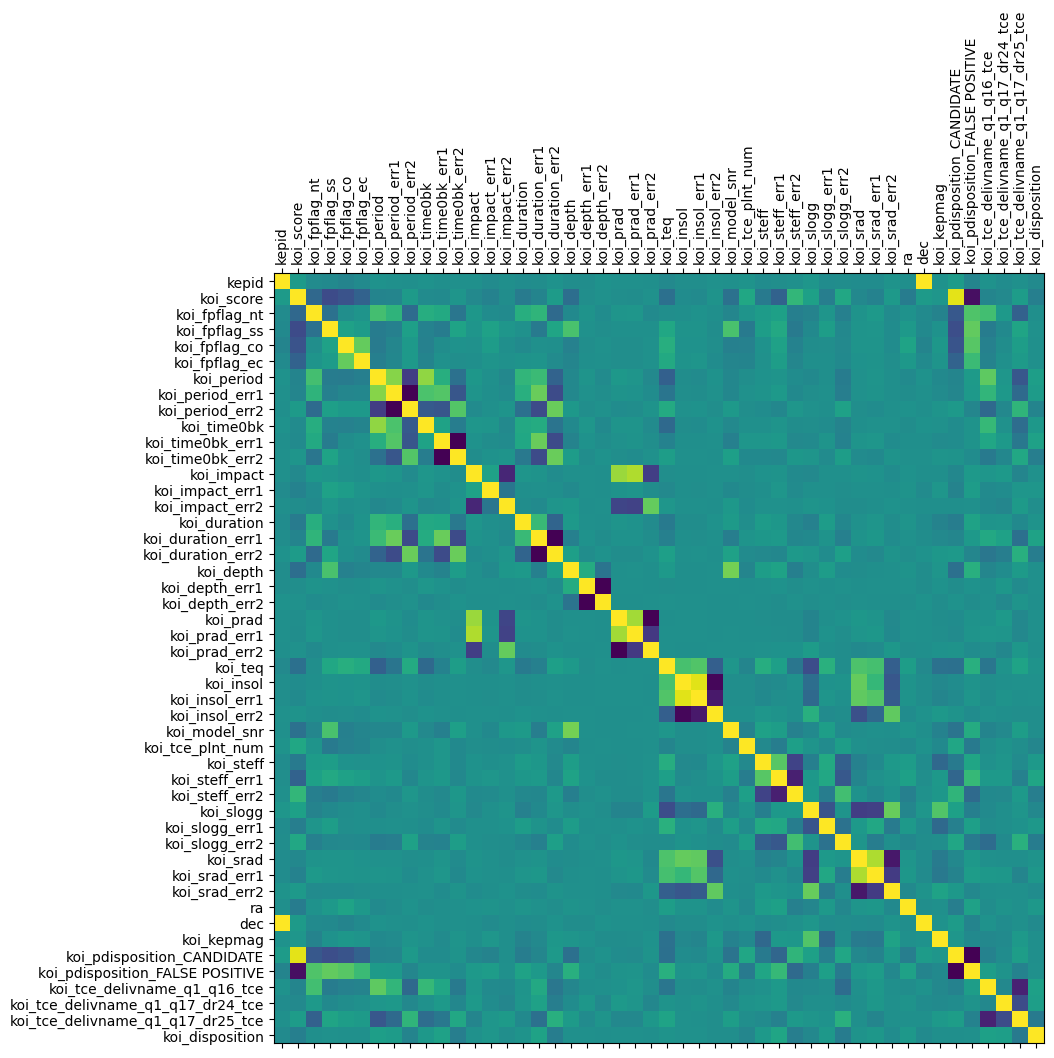

In [154]:
# Representar gráficamente la matriz de correlación
corr = df_proc.corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);
ax.tick_params("x", rotation=90)
plt.show()

In [155]:
# Se puede llegar a valorar quedarnos con aquellas que tienen mayor correlación
corr_matrix[corr_matrix["koi_disposition"] > 0.05]

,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_srad_err2,ra,dec,koi_kepmag,koi_pdisposition_CANDIDATE,koi_pdisposition_FALSE POSITIVE,koi_tce_delivname_q1_q16_tce,koi_tce_delivname_q1_q17_dr24_tce,koi_tce_delivname_q1_q17_dr25_tce,koi_disposition
koi_period,0.017482,-0.097743,0.399893,-0.159101,-0.165545,-0.137890,1.000000,0.635587,-0.635587,0.666775,...,-0.003677,-0.039632,0.016220,-0.049762,-0.093345,0.093345,0.504691,0.052734,-0.457865,0.120007
koi_period_err1,0.005397,-0.091440,0.301089,-0.126095,-0.083600,-0.075669,0.635587,1.000000,-1.000000,0.437365,...,-0.004814,-0.019264,0.004131,-0.032042,-0.081165,0.081165,0.319426,0.067292,-0.309779,0.095240
koi_time0bk,0.017210,-0.038095,0.246909,-0.115916,-0.120229,-0.098300,0.666775,0.437365,-0.437365,1.000000,...,0.008345,-0.022255,0.016224,0.008418,-0.026675,0.026675,0.336197,0.007992,-0.289010,0.064712
koi_time0bk_err1,-0.004677,-0.044178,0.212503,-0.163756,-0.022133,0.013795,0.255056,0.463167,-0.463167,0.154512,...,-0.026941,-0.003979,-0.005087,-0.034395,-0.029446,0.029446,0.180678,0.073177,-0.195918,0.140973
koi_duration_err1,-0.020687,-0.099607,0.307552,-0.178997,0.000124,0.032191,0.366642,0.540704,-0.540704,0.229951,...,-0.028521,0.010715,-0.020629,-0.058533,-0.082214,0.082214,0.210506,0.143075,-0.262340,0.152128
koi_steff,-0.027152,-0.182478,0.095977,0.109436,0.020613,0.013695,0.022263,0.029476,-0.029476,0.004137,...,0.074973,0.108085,-0.027627,-0.325012,-0.175181,0.175181,0.010369,0.041983,-0.033513,0.074991
koi_steff_err1,-0.007921,-0.368356,0.135981,0.207014,0.146357,0.112265,0.036909,0.070490,-0.070490,0.034160,...,0.046604,0.137791,-0.013190,0.063000,-0.341672,0.341672,0.080445,0.085067,-0.118166,0.176301
koi_slogg_err1,-0.026540,-0.145029,0.042540,0.114611,-0.012758,-0.002697,-0.001857,0.007553,-0.007553,-0.030058,...,-0.168450,0.082620,-0.028884,-0.317722,-0.126307,0.126307,-0.016014,-0.005350,0.016695,0.067236
koi_srad_err1,-0.030568,-0.111897,0.072920,0.040120,0.033327,0.029923,0.032518,0.027346,-0.027346,0.009697,...,-0.652946,0.056414,-0.031893,-0.191549,-0.108636,0.108636,0.067519,0.057738,-0.091128,0.058661
ra,-0.003381,-0.156570,0.015822,0.082717,0.156628,0.068720,-0.039632,-0.019264,0.019264,-0.022255,...,-0.048652,1.000000,-0.015601,0.005896,-0.144456,0.144456,-0.022108,0.026240,0.003229,0.063238


### Reducción del número de características

In [156]:
# Extraemos las 12 caracteristicas con mas relevancia para el algoritmo
columns = list(corr_matrix[corr_matrix["koi_disposition"] > 0.05].index)
columns.remove("koi_disposition")

In [157]:
columns

['koi_period',
 'koi_period_err1',
 'koi_time0bk',
 'koi_time0bk_err1',
 'koi_duration_err1',
 'koi_steff',
 'koi_steff_err1',
 'koi_slogg_err1',
 'koi_srad_err1',
 'ra',
 'koi_tce_delivname_q1_q16_tce',
 'koi_tce_delivname_q1_q17_dr24_tce']

In [158]:
X_df_reduced = df_proc[columns].copy()

In [159]:
X_df_reduced

,koi_period,koi_period_err1,koi_time0bk,koi_time0bk_err1,koi_duration_err1,koi_steff,koi_steff_err1,koi_slogg_err1,koi_srad_err1,ra,koi_tce_delivname_q1_q16_tce,koi_tce_delivname_q1_q17_dr24_tce
rowid,,,,,,,,,,,,
1,9.488036,2.775000e-05,170.538750,0.002160,0.08190,5455.0,81.0,0.064,0.105,291.93423,0.0,0.0
2,54.418383,2.479000e-04,162.513840,0.003520,0.11600,5455.0,81.0,0.064,0.105,291.93423,0.0,0.0
3,19.899140,1.494000e-05,175.850252,0.000581,0.03410,5853.0,158.0,0.044,0.233,297.00482,0.0,0.0
4,1.736952,2.630000e-07,170.307565,0.000115,0.00537,5805.0,157.0,0.053,0.201,285.53461,0.0,0.0
5,2.525592,3.761000e-06,171.595550,0.001130,0.04200,6031.0,169.0,0.070,0.334,288.75488,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9560,8.589871,1.846000e-04,132.016100,0.015700,0.63400,5638.0,169.0,0.231,0.313,298.74921,0.0,0.0
9561,0.527699,1.160000e-07,131.705093,0.000170,0.01740,5638.0,139.0,0.035,0.237,297.18875,0.0,0.0
9562,1.739849,1.780000e-05,133.001270,0.007690,0.22900,6119.0,165.0,0.056,0.341,286.50937,0.0,0.0


In [160]:
df_reduced = X_df_reduced.join(y_df)

In [161]:
df_reduced

,koi_period,koi_period_err1,koi_time0bk,koi_time0bk_err1,koi_duration_err1,koi_steff,koi_steff_err1,koi_slogg_err1,koi_srad_err1,ra,koi_tce_delivname_q1_q16_tce,koi_tce_delivname_q1_q17_dr24_tce,koi_disposition
rowid,,,,,,,,,,,,,
1,9.488036,2.775000e-05,170.538750,0.002160,0.08190,5455.0,81.0,0.064,0.105,291.93423,0.0,0.0,CONFIRMED
2,54.418383,2.479000e-04,162.513840,0.003520,0.11600,5455.0,81.0,0.064,0.105,291.93423,0.0,0.0,CONFIRMED
3,19.899140,1.494000e-05,175.850252,0.000581,0.03410,5853.0,158.0,0.044,0.233,297.00482,0.0,0.0,FALSE POSITIVE
4,1.736952,2.630000e-07,170.307565,0.000115,0.00537,5805.0,157.0,0.053,0.201,285.53461,0.0,0.0,FALSE POSITIVE
5,2.525592,3.761000e-06,171.595550,0.001130,0.04200,6031.0,169.0,0.070,0.334,288.75488,0.0,0.0,CONFIRMED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,8.589871,1.846000e-04,132.016100,0.015700,0.63400,5638.0,169.0,0.231,0.313,298.74921,0.0,0.0,FALSE POSITIVE
9561,0.527699,1.160000e-07,131.705093,0.000170,0.01740,5638.0,139.0,0.035,0.237,297.18875,0.0,0.0,FALSE POSITIVE
9562,1.739849,1.780000e-05,133.001270,0.007690,0.22900,6119.0,165.0,0.056,0.341,286.50937,0.0,0.0,CANDIDATE


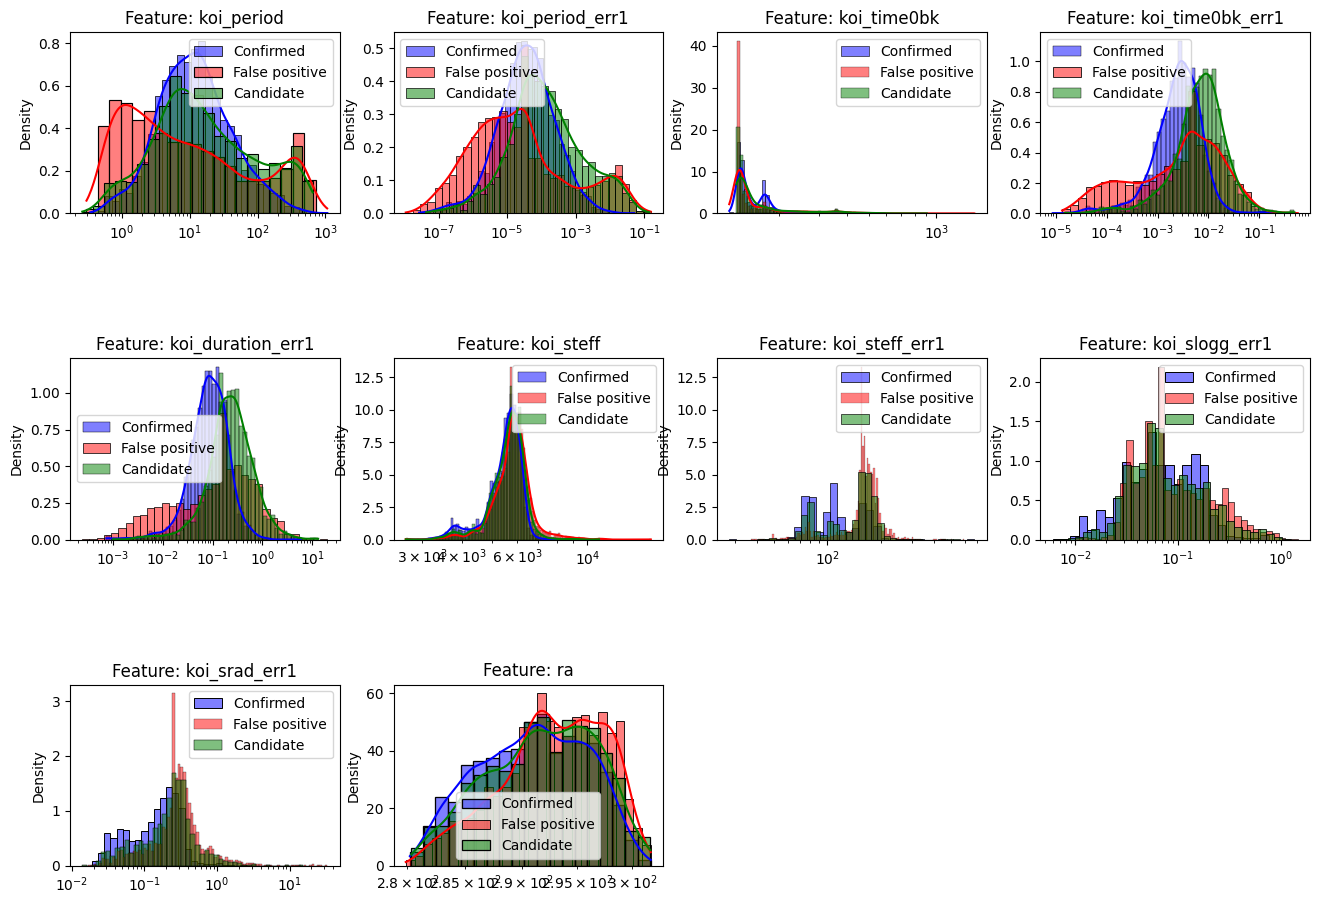

In [162]:
# Representamos gráficamente las características del conjunto de datos reducido
features = df_reduced.drop(["koi_disposition", "koi_tce_delivname_q1_q16_tce","koi_tce_delivname_q1_q17_dr24_tce"], axis=1)

plt.figure(figsize=(16, 32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde koi_disposition == CONFIRMED
    sns.histplot(data=df_reduced[df_reduced["koi_disposition"] == "CONFIRMED"], x=f, kde=True, color="blue", stat="density", label="Confirmed", alpha=0.5, log_scale=True)
    # Usando histplot para los casos donde koi_disposition == FALSE POSITIVE
    sns.histplot(data=df_reduced[df_reduced["koi_disposition"] == "FALSE POSITIVE"], x=f, kde=True, color="red", stat="density", label="False positive", alpha=0.5, log_scale=True)
    # Usando histplot para los casos donde koi_disposition == CANDIDATE
    sns.histplot(data=df_reduced[df_reduced["koi_disposition"] == "CANDIDATE"], x=f, kde=True, color="green", stat="density", label="Candidate", alpha=0.5, log_scale=True)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

### Detección de outliers

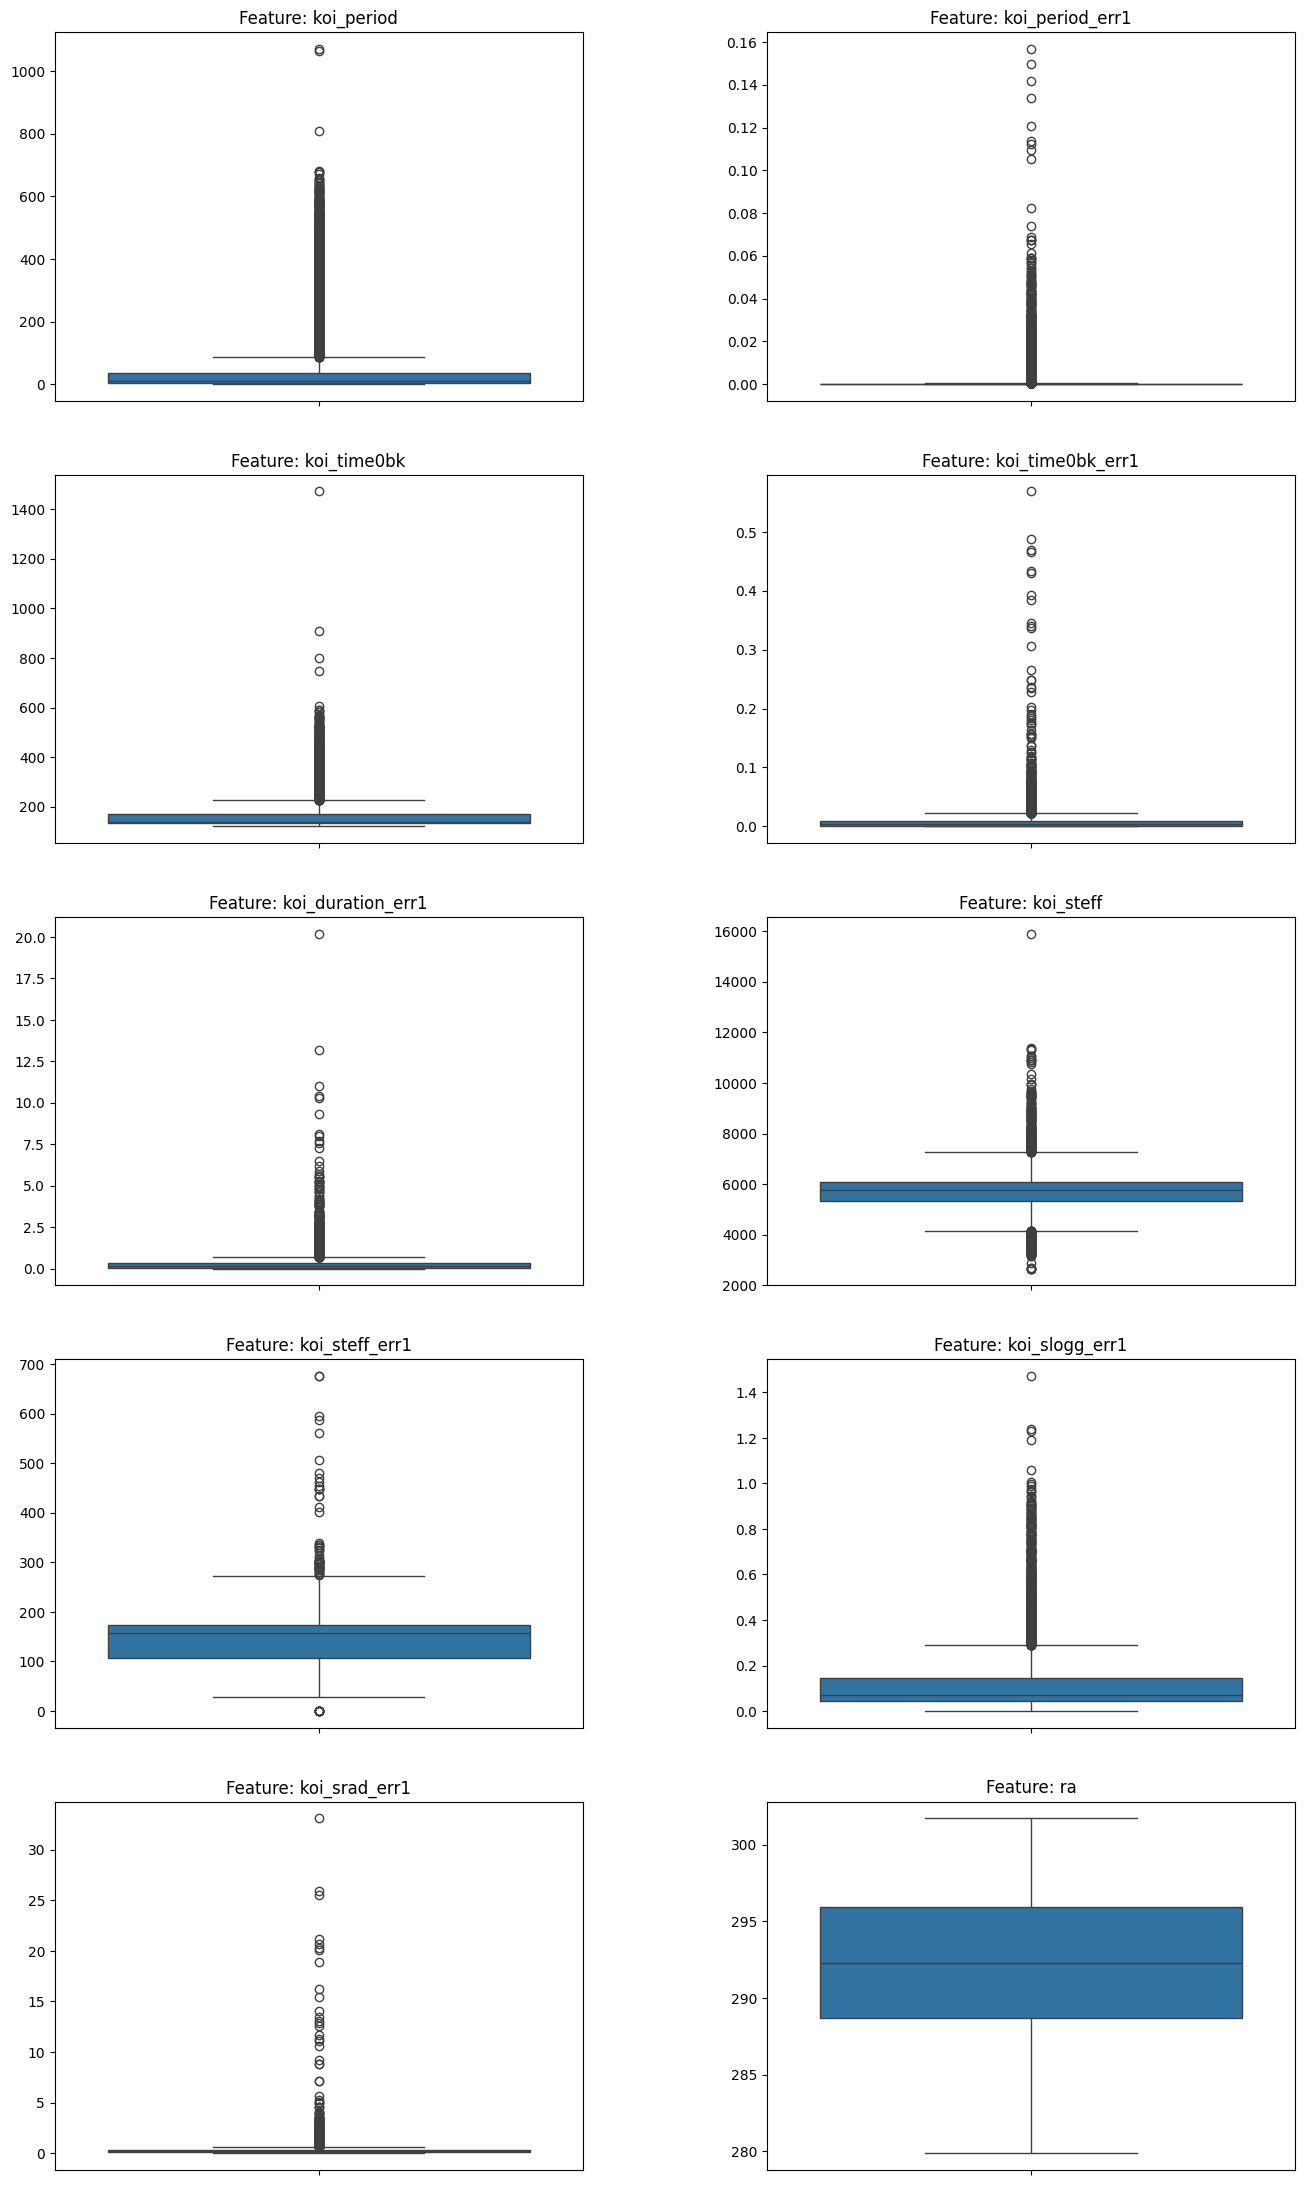

In [163]:
# Detección con método gráfico
features = df_reduced.drop(["koi_disposition", "koi_tce_delivname_q1_q16_tce","koi_tce_delivname_q1_q17_dr24_tce"], axis=1)

plt.figure(figsize=(16, 45))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.35, hspace=0.2)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Boxplots por clase
    sns.boxplot(data=df_reduced[f], ax=ax)
    ax.set_ylabel('')
    ax.set_title(f"Feature: {f}")

plt.show()

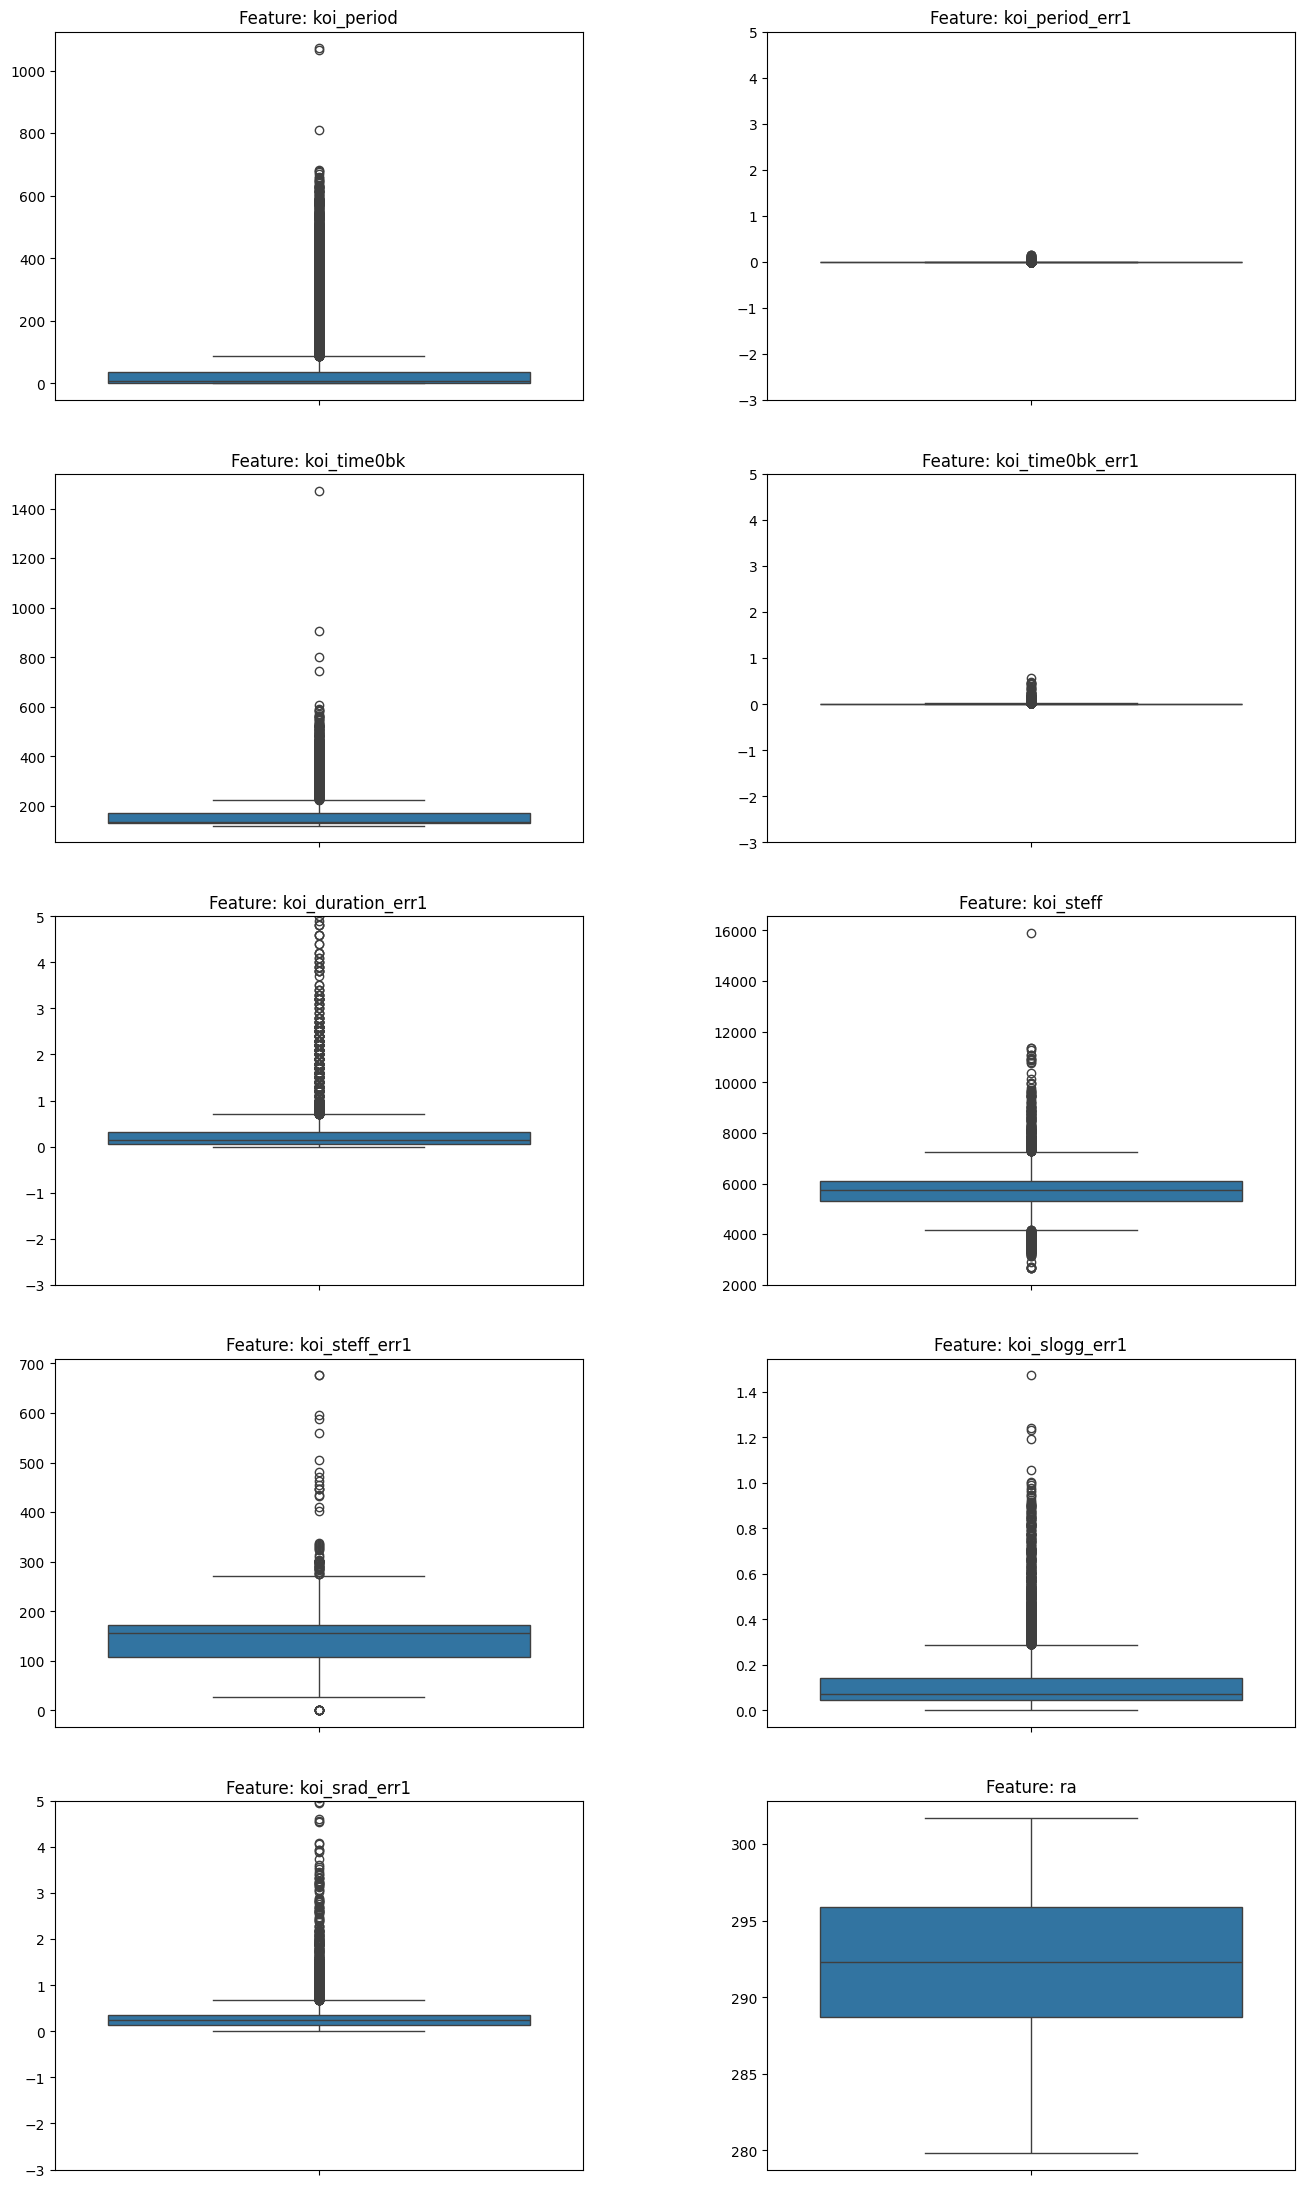

In [164]:
# Detección con método gráfico
features = df_reduced.drop(["koi_disposition", "koi_tce_delivname_q1_q16_tce","koi_tce_delivname_q1_q17_dr24_tce"], axis=1)

plt.figure(figsize=(16, 45))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.35, hspace=0.2)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Boxplots para features con mediana entre (-1,1)
    if -1 < df_reduced[f].median() < 1 and f != "koi_slogg_err1":
        sns.boxplot(data=df_reduced[f], ax=ax)
        ax.set_ylabel('')
        ax.set_title(f"Feature: {f}")
        ax.set_ylim(-3,5)
    # Boxplots para el resto de features
    else:
        sns.boxplot(data=df_reduced[f], ax=ax)
        ax.set_ylabel('')
        ax.set_title(f"Feature: {f}")

plt.show()

In [165]:
# Usamos el transformador SubstiteOutliersMedian para sustituir outliers con la mediana de algunas características
outlier_median = SubstituteOutliersMedian(["koi_period",
                              "koi_period_err1",
                              "koi_time0bk",  
                              "koi_steff_err1",
                              "koi_slogg_err1"])
df_wo = outlier_median.fit_transform(df_reduced)

# Usamos el transformador SubstiteOutliersMean para sustituir outliers con la media de algunas características
outlier_mean = SubstituteOutliersMean(["koi_time0bk_err1",  
                              "koi_duration_err1",
                              "koi_steff",
                              "koi_srad_err1"])
df_wo = outlier_mean.fit_transform(df_reduced)

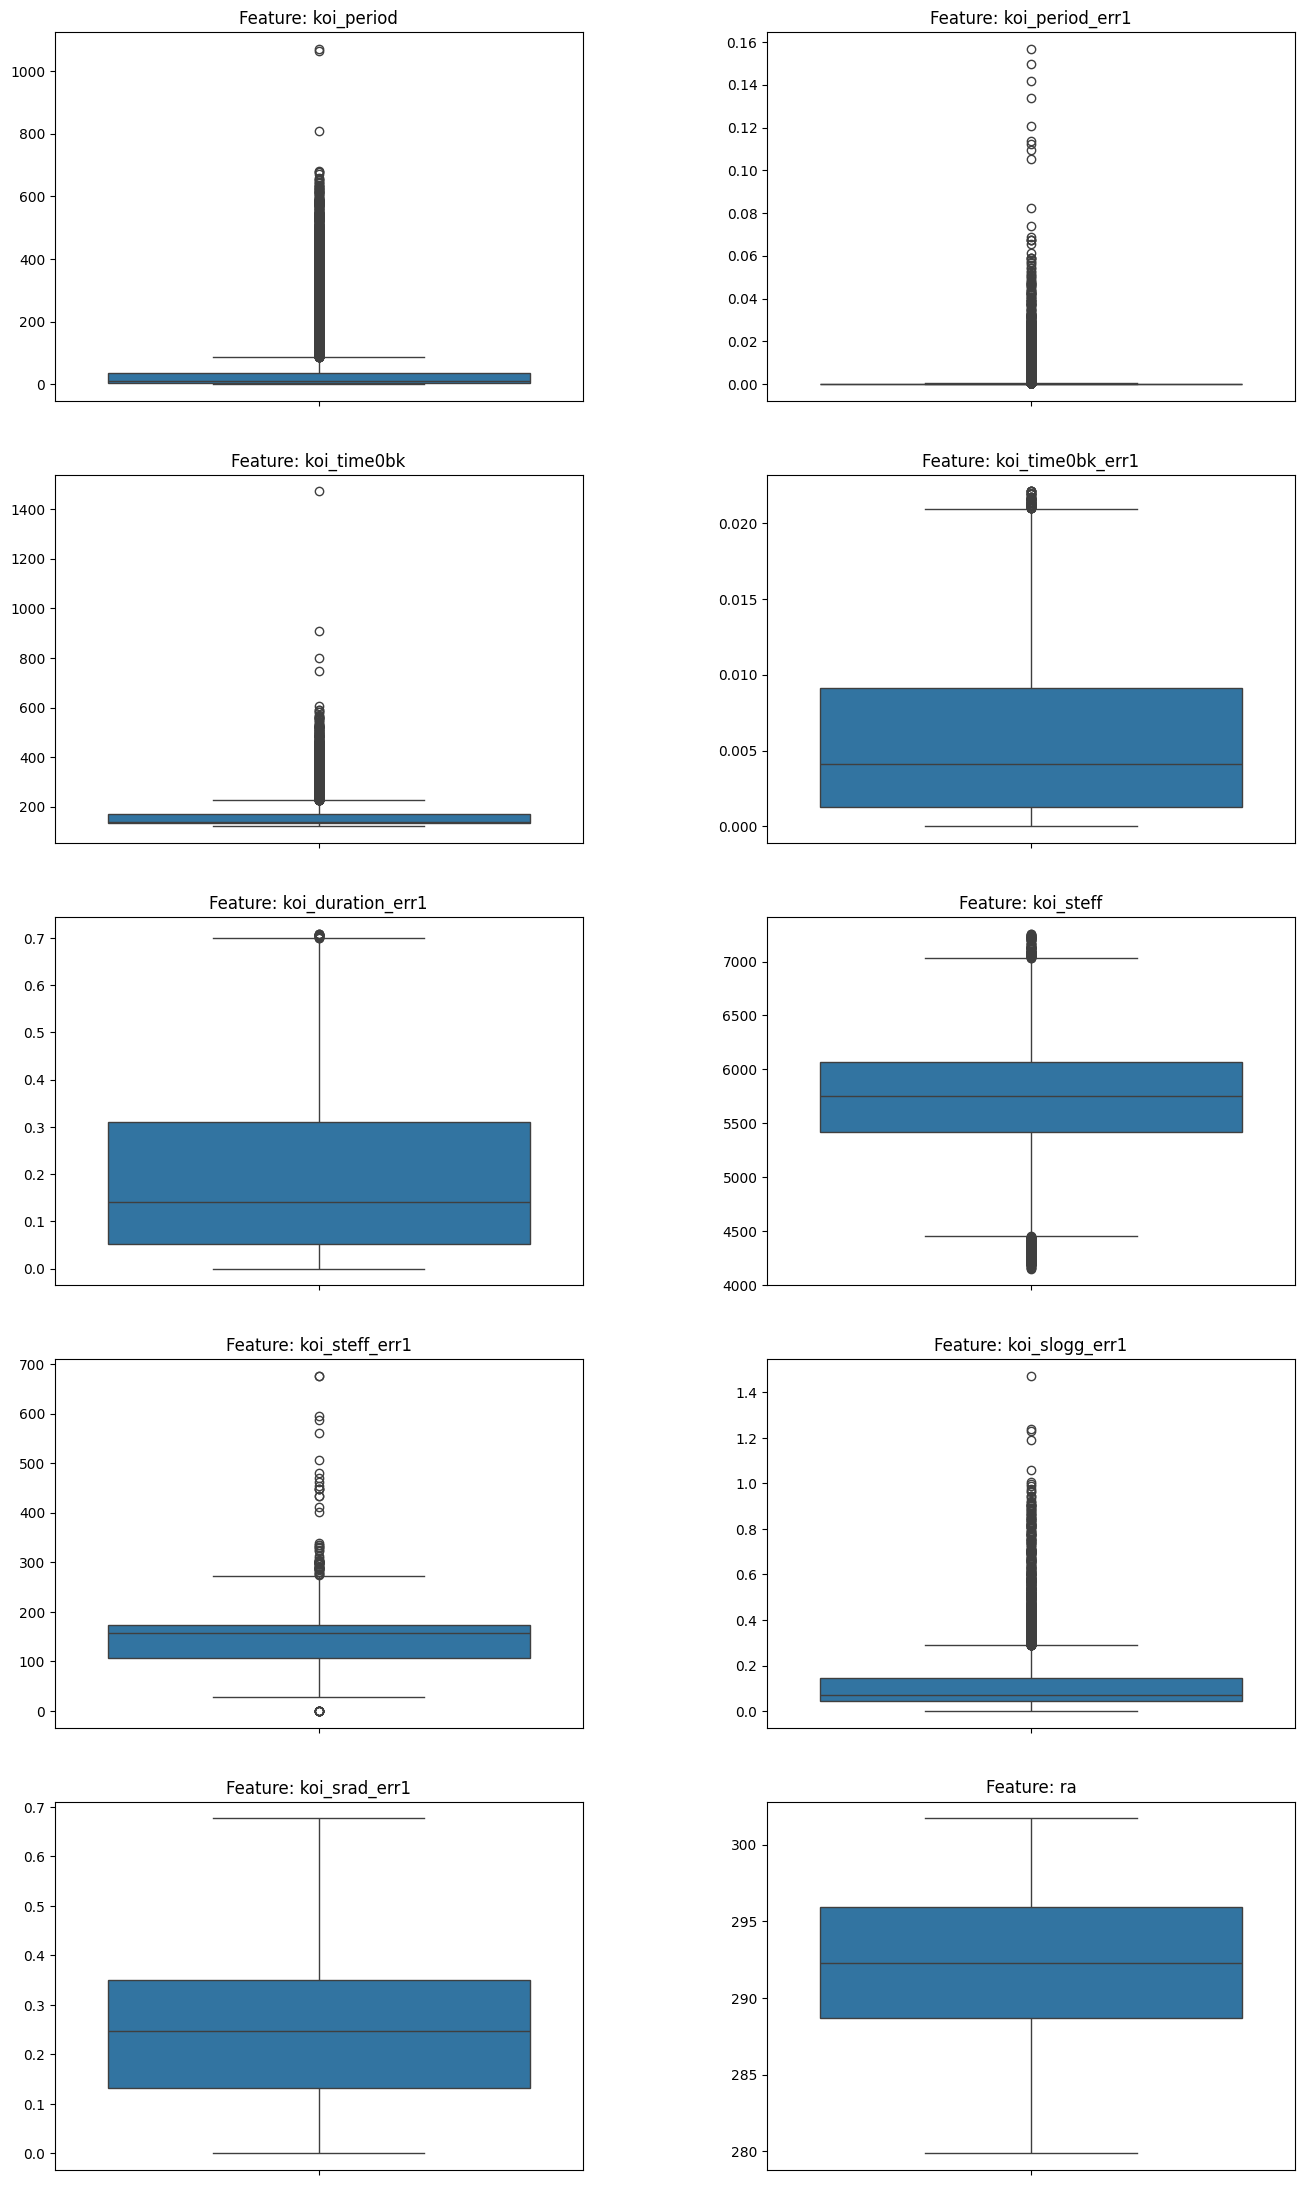

In [166]:
# Detección con método gráfico
features = df_wo.drop(["koi_disposition", "koi_tce_delivname_q1_q16_tce","koi_tce_delivname_q1_q17_dr24_tce"], axis=1)

plt.figure(figsize=(16, 45))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.35, hspace=0.2)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Boxplots por clase
    sns.boxplot(data=df_wo[f], ax=ax)
    ax.set_ylabel('')
    ax.set_title(f"Feature: {f}")

plt.show()

In [167]:
df_wo

,koi_period,koi_period_err1,koi_time0bk,koi_time0bk_err1,koi_duration_err1,koi_steff,koi_steff_err1,koi_slogg_err1,koi_srad_err1,ra,koi_tce_delivname_q1_q16_tce,koi_tce_delivname_q1_q17_dr24_tce,koi_disposition
rowid,,,,,,,,,,,,,
1,9.488036,2.775000e-05,170.538750,0.002160,0.08190,5455.0,81.0,0.064,0.105,291.93423,0.0,0.0,CONFIRMED
2,54.418383,2.479000e-04,162.513840,0.003520,0.11600,5455.0,81.0,0.064,0.105,291.93423,0.0,0.0,CONFIRMED
3,19.899140,1.494000e-05,175.850252,0.000581,0.03410,5853.0,158.0,0.044,0.233,297.00482,0.0,0.0,FALSE POSITIVE
4,1.736952,2.630000e-07,170.307565,0.000115,0.00537,5805.0,157.0,0.053,0.201,285.53461,0.0,0.0,FALSE POSITIVE
5,2.525592,3.761000e-06,171.595550,0.001130,0.04200,6031.0,169.0,0.070,0.334,288.75488,0.0,0.0,CONFIRMED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9560,8.589871,1.846000e-04,132.016100,0.015700,0.63400,5638.0,169.0,0.231,0.313,298.74921,0.0,0.0,FALSE POSITIVE
9561,0.527699,1.160000e-07,131.705093,0.000170,0.01740,5638.0,139.0,0.035,0.237,297.18875,0.0,0.0,FALSE POSITIVE
9562,1.739849,1.780000e-05,133.001270,0.007690,0.22900,6119.0,165.0,0.056,0.341,286.50937,0.0,0.0,CANDIDATE


### Escalado de características

In [177]:
# Usamos el transformador custonScaler para escalar algunas características
custom_scaler = CustomScaler(["koi_period", 
                              "koi_period_err1",
                              "koi_time0bk",  
                              "koi_time0bk_err1", 
                              "koi_duration_err1",
                              "koi_srad_err1"])
df_scaled = custom_scaler.fit_transform(df_wo)

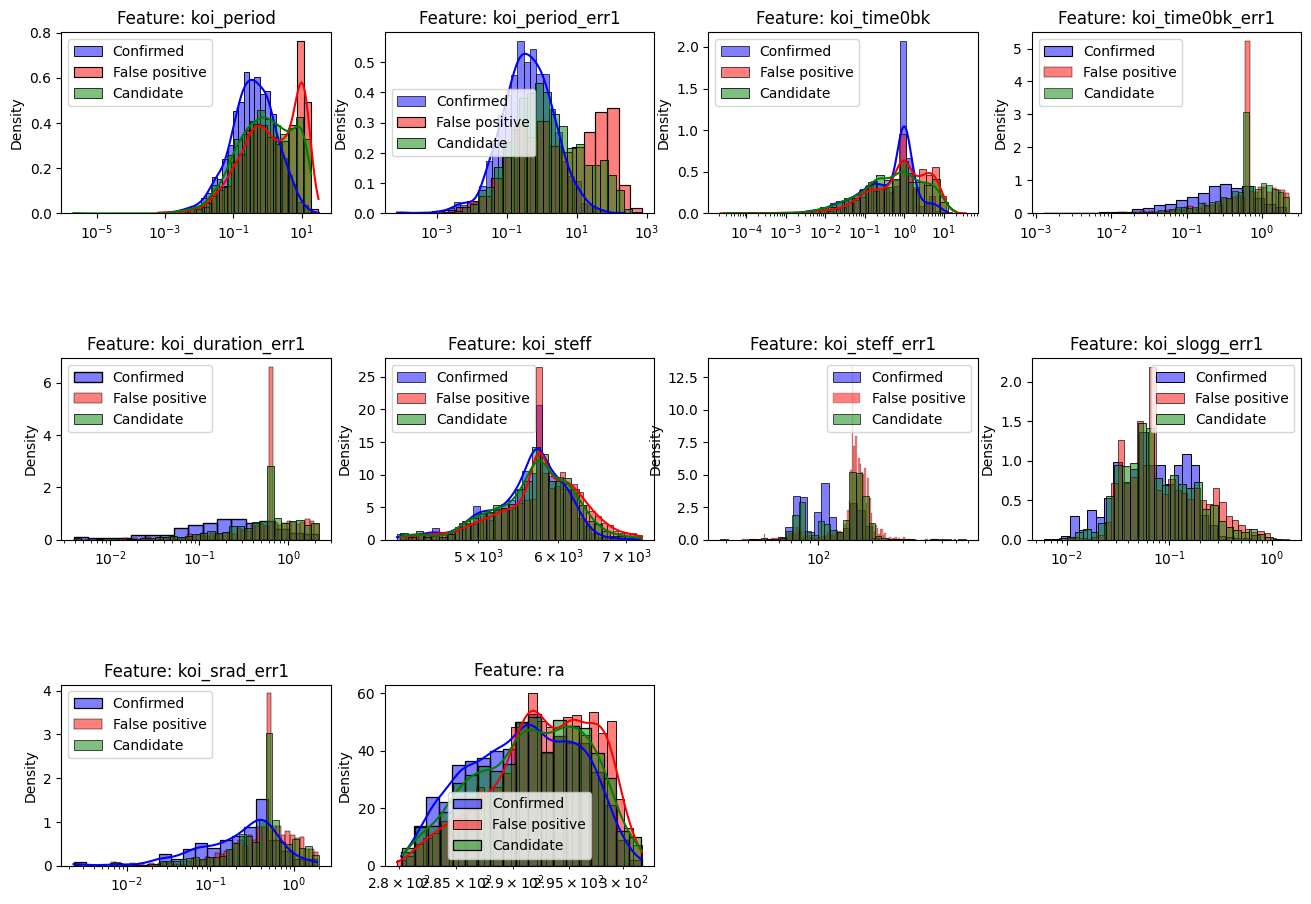

In [178]:
# Representamos gráficamente las características del conjunto de datos reducido
features = df_scaled.drop(["koi_disposition", "koi_tce_delivname_q1_q16_tce","koi_tce_delivname_q1_q17_dr24_tce"], axis=1)

plt.figure(figsize=(16, 32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde koi_disposition == CONFIRMED
    sns.histplot(data=df_scaled[df_scaled["koi_disposition"] == "CONFIRMED"], x=f, kde=True, color="blue", stat="density", label="Confirmed", alpha=0.5, log_scale=True)
    # Usando histplot para los casos donde koi_disposition == FALSE POSITIVE
    sns.histplot(data=df_scaled[df_scaled["koi_disposition"] == "FALSE POSITIVE"], x=f, kde=True, color="red", stat="density", label="False positive", alpha=0.5, log_scale=True)
    # Usando histplot para los casos donde koi_disposition == CANDIDATE
    sns.histplot(data=df_scaled[df_scaled["koi_disposition"] == "CANDIDATE"], x=f, kde=True, color="green", stat="density", label="Candidate", alpha=0.5, log_scale=True)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

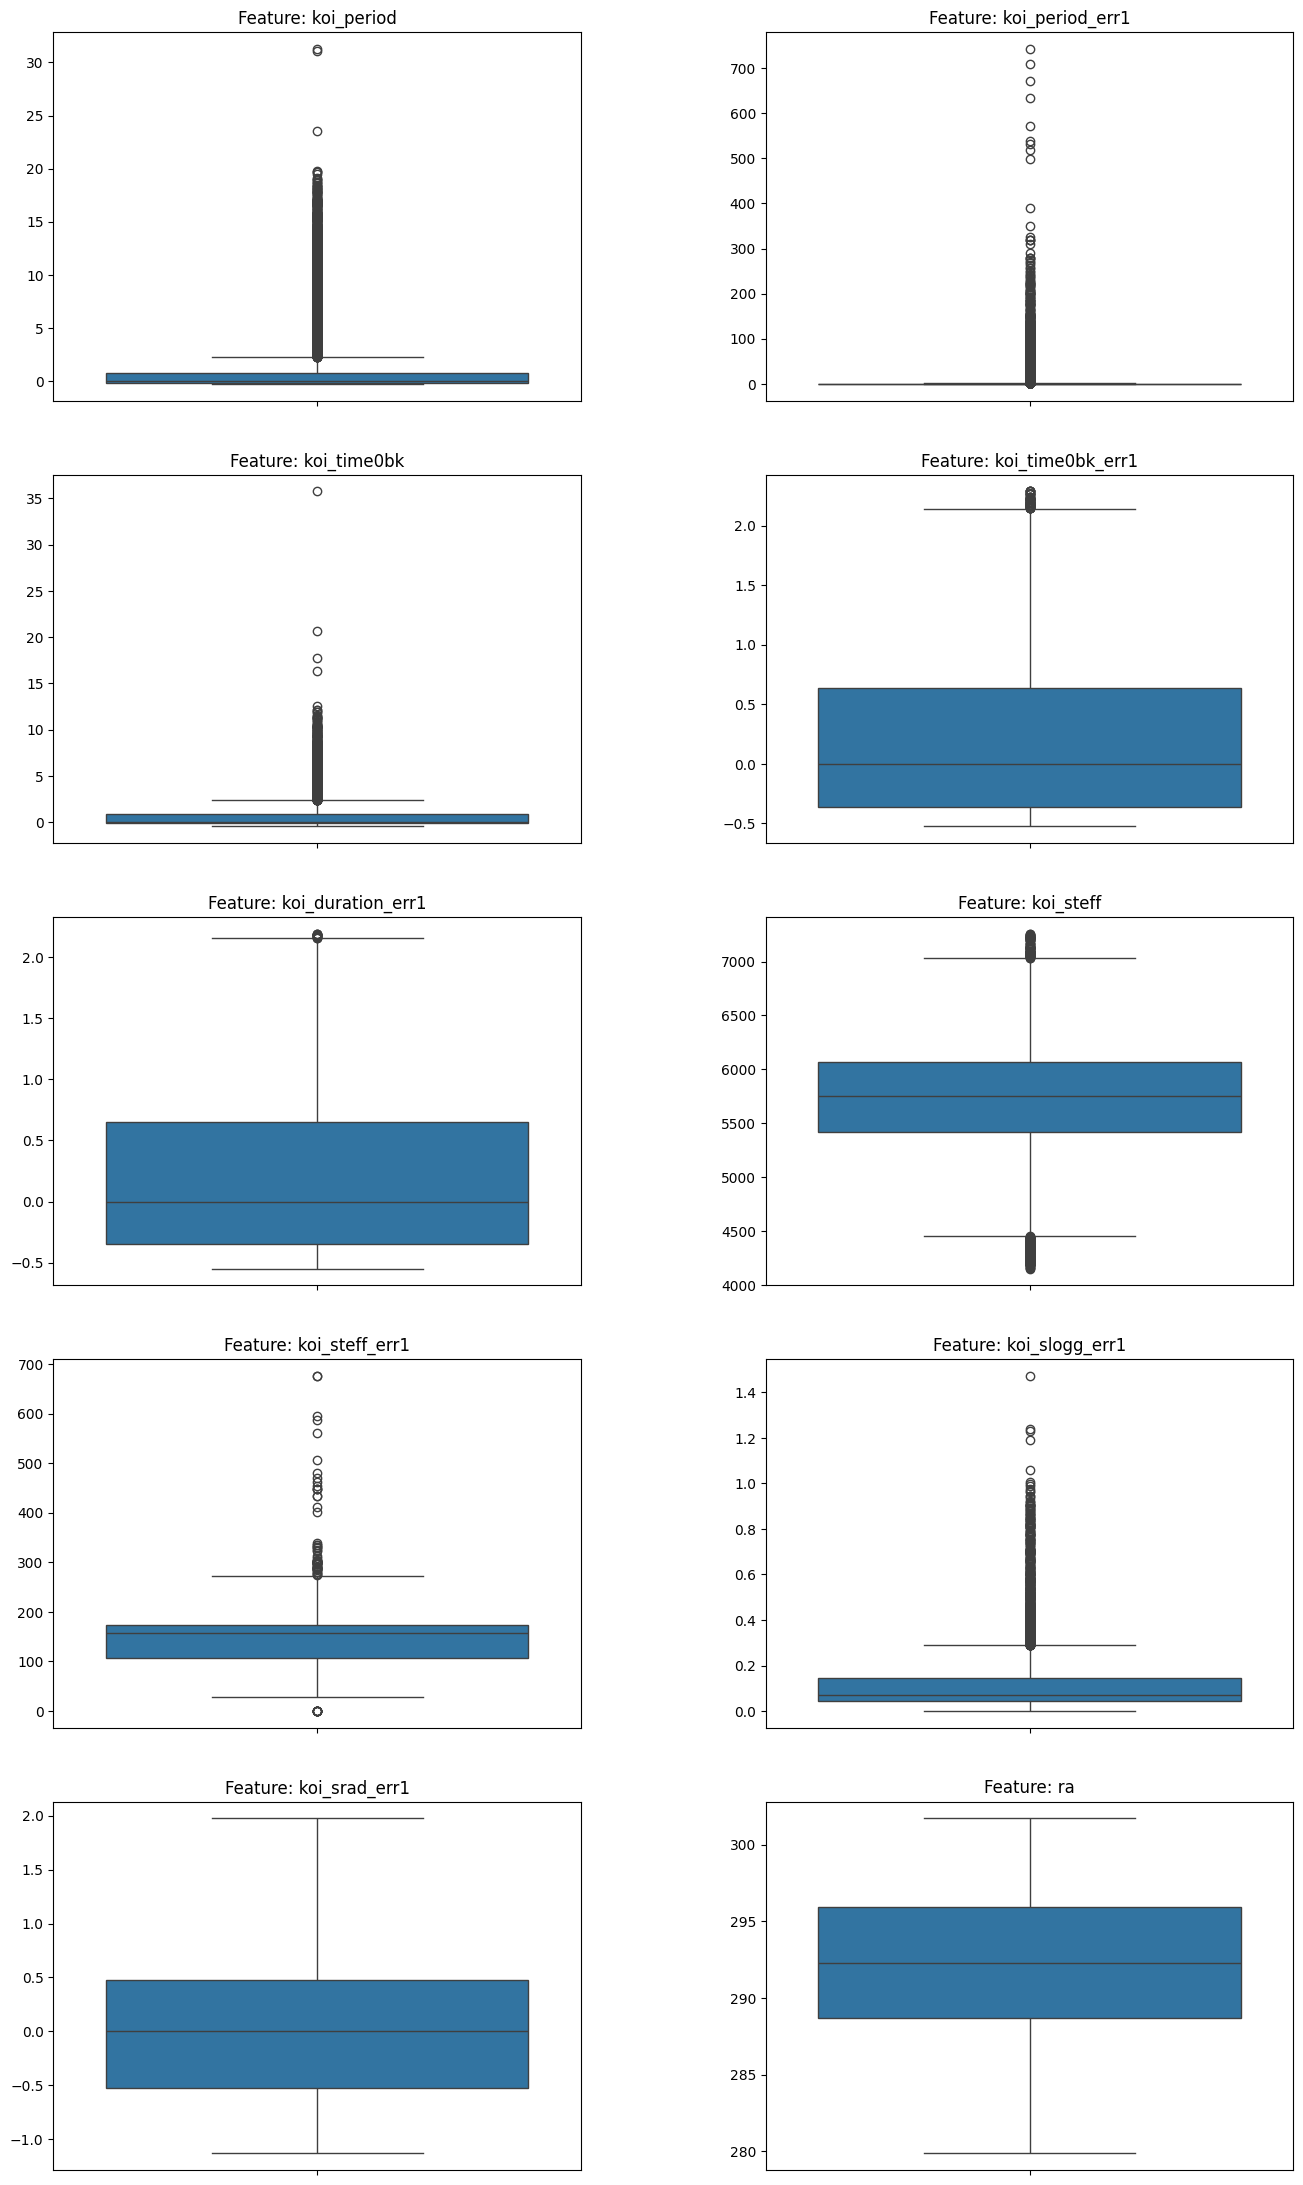

In [179]:
# Representamos gráficamente los otliers del conjunto de datos escalado
features = df_scaled.drop(["koi_disposition", "koi_tce_delivname_q1_q16_tce","koi_tce_delivname_q1_q17_dr24_tce"], axis=1)

plt.figure(figsize=(16, 45))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.35, hspace=0.2)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Boxplots por clase
    sns.boxplot(data=df_scaled[f], ax=ax)
    ax.set_ylabel('')
    ax.set_title(f"Feature: {f}")


## Extracción de características-PCA

In [169]:
# Reducimos el conjunto de datos manteniendo el 99,9% de varianza
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99999999)
df_reduced_PCA = pca.fit_transform(X_df_reduced)

In [170]:
# Numero de dimensionaes del nuevo conjunto
print("Número de componentes:", pca.n_components_)

Número de componentes: 10


In [171]:
# Calculamos la proporción de varianza que se ha preservado del conjunto original
pca.explained_variance_ratio_

array([9.68337521e-01, 2.56790251e-02, 3.35111884e-03, 2.59528600e-03,
       3.50287350e-05, 1.30524761e-06, 5.40966802e-07, 9.34168875e-08,
       5.62321765e-08, 2.38673023e-08])

In [173]:
# Transformamos a un DataFrame de Pandas
df_reduced_PCA = pd.DataFrame(df_reduced_PCA, columns=["c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10"])
df_reduced_PCA["koi_disposition"] = y_df
df_reduced_PCA

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,koi_disposition
0,-248.824813,-41.475931,20.551045,-57.706910,0.577212,-0.209528,-0.070471,0.004808,-0.002498,-0.018189,NaN
1,-248.673232,-3.697435,-5.025845,-56.400910,0.670790,-0.234175,-0.130065,-0.045360,-0.019171,-0.021718,CONFIRMED
2,151.236409,-30.365410,26.064701,7.684917,4.625498,-0.171682,-0.212722,-0.028084,-0.032577,-0.085780,CONFIRMED
3,103.155398,-49.030366,28.349226,7.973832,-6.849403,-0.059744,-0.184879,-0.017587,-0.023466,-0.062189,FALSE POSITIVE
4,329.408641,-48.472699,29.825841,13.505664,-3.843294,0.045712,-0.175169,-0.019365,-0.032246,-0.063049,FALSE POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...
9213,-63.418963,-57.617157,-8.330218,27.507551,6.311356,-0.109397,0.389554,-0.024846,-0.080557,0.092817,FALSE POSITIVE
9214,-64.298166,-65.455149,-7.384230,-2.542173,5.087208,-0.180196,-0.183133,-0.000211,-0.024385,-0.085468,CANDIDATE
9215,417.240158,-65.250137,-5.373299,9.573957,-6.052950,0.086537,0.007139,-0.016403,-0.042392,-0.080245,FALSE POSITIVE
9216,472.012780,-66.433118,-3.812629,36.091126,1.250864,-0.025375,-0.088825,-0.018550,-0.051484,-0.099244,CANDIDATE


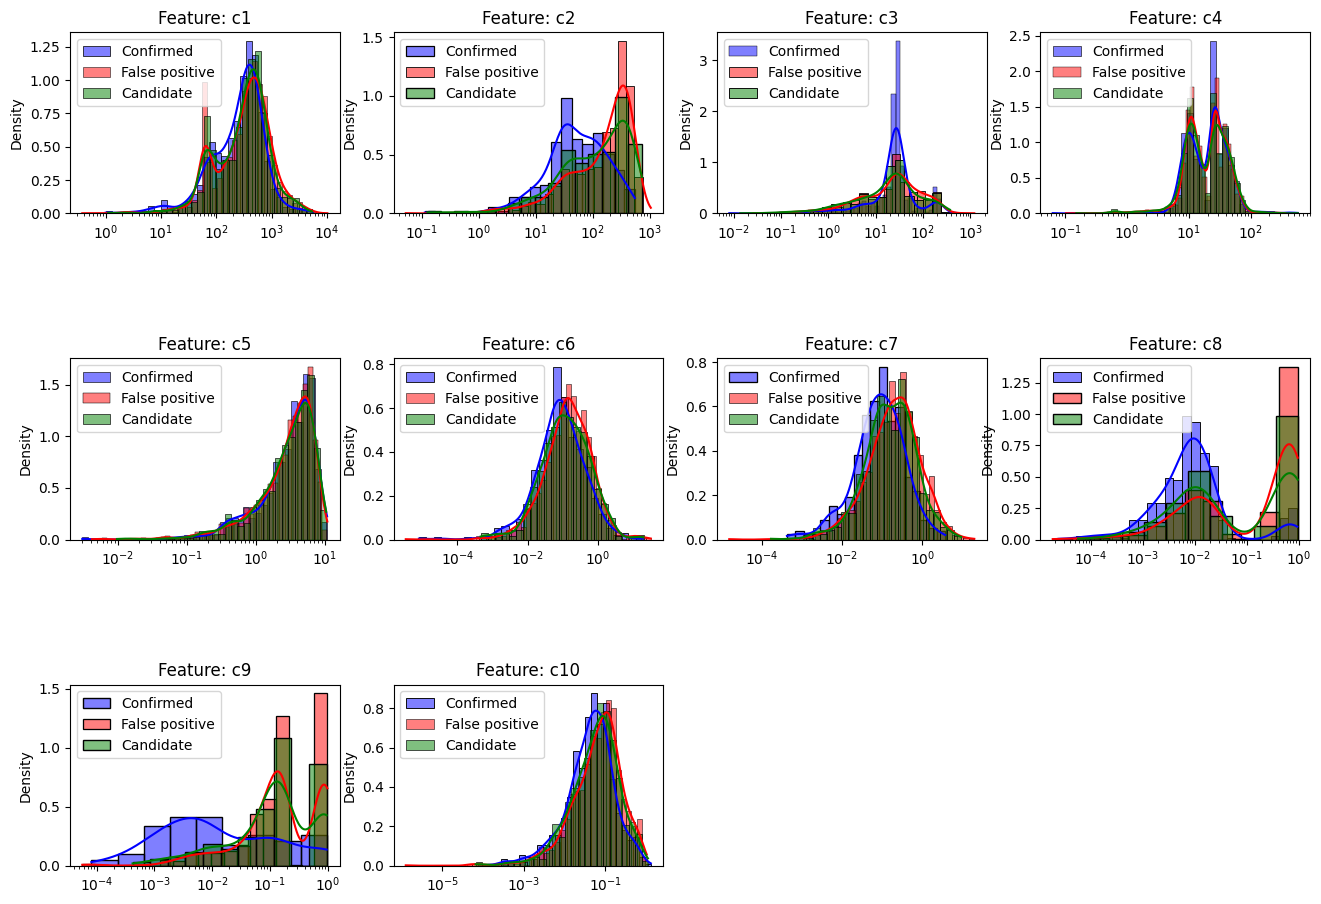

In [174]:
# Representamos gráficamente las características del conj. de datos reducido con PCA
features = df_reduced_PCA.drop("koi_disposition", axis=1)

plt.figure(figsize=(16, 32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde koi_disposition == CONFIRMED
    sns.histplot(data=df_reduced_PCA[df_reduced_PCA["koi_disposition"] == "CONFIRMED"], x=f, kde=True, color="blue", stat="density", label="Confirmed", alpha=0.5, log_scale=True)
    # Usando histplot para los casos donde koi_disposition == FALSE POSITIVE
    sns.histplot(data=df_reduced_PCA[df_reduced_PCA["koi_disposition"] == "FALSE POSITIVE"], x=f, kde=True, color="red", stat="density", label="False positive", alpha=0.5, log_scale=True)
    # Usando histplot para los casos donde koi_disposition == CANDIDATE
    sns.histplot(data=df_reduced_PCA[df_reduced_PCA["koi_disposition"] == "CANDIDATE"], x=f, kde=True, color="green", stat="density", label="Candidate", alpha=0.5, log_scale=True)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

## División del conjunto de datos (Conjunto de datos no reducido)

In [ ]:
#train_set, val_set, test_set = train_val_test_split(df_prep)

In [ ]:
#X_train, y_train = remove_labels(train_set, 'koi_disposition')
#X_val, y_val = remove_labels(val_set, 'koi_disposition')
#X_test, y_test = remove_labels(test_set, 'koi_disposition')

## Random Forests (Conjunto de datos no reducido)

In [ ]:
#from sklearn.ensemble import RandomForestClassifier

#clf_rnd = RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1)
#clf_rnd.fit(X_train, y_train)

,n_estimators,10000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Predecimos con el conjunto de datos de entrenamiento
#y_train_pred = clf_rnd.predict(X_train)

In [ ]:
#print("F1 Score Train Set:", f1_score(y_train_pred, y_train, average='weighted'))

F1 Score Train Set: 1.0


In [ ]:
# Predecimos con el conjunto de datos de validación
#y_val_pred = clf_rnd.predict(X_val)

In [ ]:
#print("F1 Score Validation Set:", f1_score(y_val_pred, y_val, average='weighted'))

F1 Score Validation Set: 0.7257452836950934


In [ ]:
# Predecimos con el conjunto de datos de prueba
#y_test_pred = clf_rnd.predict(X_test)

In [ ]:
#print("F1 Score Validation Set:", f1_score(y_test_pred, y_test, average='weighted'))

F1 Score Validation Set: 0.7368409154870417
